<a href="https://colab.research.google.com/github/Danboruya/data-mining-lecture-works/blob/master/data_analyze_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data-mining lecture works
In this notebook, we analyze the text data of movie review used in my graduation research.  
We show the visualization of word embeddings.

## Notebook Setup
Install the following necessary libraries.
* Tensorflow-gpu 2.0 bata
* h5py
* pyyaml
* hyperdash (For loging on mobile)

In [0]:
!pip install -q tensorflow-gpu==2.0.0-beta1
!pip install -q h5py pyyaml hyperdash

Mount the my Google Drive

In [0]:
from google.colab import drive
drive.mount('/gdrive')

Get API key and setup hyperdash.

In [0]:
!hyperdash signup --github

## Import libraries

In [0]:
import re
import tensorflow as tf
import random
import numpy as np
import io
import os
import time
import matplotlib.pyplot as plt
from tensorboard.plugins import projector
from hyperdash import monitor_cell
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model

## Load data

In [0]:
with open('/gdrive/My Drive/Colab Notebooks/data/rt-polaritydata/rt-polarity-utf8.pos', 'r') as f:
    raw_positive_sentences = f.readlines()
    raw_positive_sentences = [raw_sentence.replace(' \n', '') for raw_sentence in raw_positive_sentences]

In [0]:
with open('/gdrive/My Drive/Colab Notebooks/data/rt-polaritydata/rt-polarity-utf8.neg', 'r') as f:
    raw_negative_sentences = f.readlines()
    raw_negative_sentences = [raw_sentence.replace(' \n', '') for raw_sentence in raw_negative_sentences]

## Pre-processings

In [0]:
def _string_cleaner(string):
    """
    Tokenization/string cleaning for all datasets except for SST.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()

In [0]:
raw_positive_sentences = [_string_cleaner(sentence) for sentence in raw_positive_sentences]
raw_negative_sentences = [_string_cleaner(sentence) for sentence in raw_negative_sentences]

In [0]:
vocab = ['<unk>']

for sentence in raw_positive_sentences:
    for word in sentence.split(" "):
        if word not in vocab:
            vocab.append(word)

for sentence in raw_negative_sentences:
    for word in sentence.split(" "):
        if word not in vocab:
            vocab.append(word)

In [0]:
len(vocab)

18765

In [0]:
positive_sentences = []
negative_sentences = []
positive_labels = []
negative_labels = []
all_sentences = []
all_labels = []
sentence_length = 0

for sentence in raw_positive_sentences:
    s = []
    for word in sentence.split(" "):
        s.append(vocab.index(word))
    positive_sentences.append(s)
    positive_labels.append(1)
    all_sentences.append(s)
    all_labels.append(1)

for sentence in raw_negative_sentences:
    s = []
    for word in sentence.split(" "):
        s.append(vocab.index(word))
    negative_sentences.append(s)
    negative_labels.append(0)
    all_sentences.append(s)
    all_labels.append(0)
    
for sentence in positive_sentences:
    if sentence_length < len(sentence):
        sentence_length = len(sentence)
        
for sentence in negative_sentences:
    if sentence_length < len(sentence):
        sentence_length = len(sentence)

In [0]:
print(positive_sentences[0])
print(raw_positive_sentences[0])
print(sentence_length)

[1, 2, 3, 4, 5, 6, 1, 7, 8, 9, 10, 11, 12, 13, 14, 9, 15, 5, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
the rock is destined to be the 21st century 's new conan and that he 's going to make a splash even greater than arnold schwarzenegger , jean claud van damme or steven segal
56


In [0]:
def paddinger(sentence_list, sentence_length):
    for sentence in sentence_list:
        if len(sentence) != sentence_length:
            padding_list = [0 for _ in range(0, sentence_length - len(sentence))]
            sentence.extend(padding_list)
    return sentence_list

In [0]:
positive_sentences = paddinger(positive_sentences, sentence_length)
negative_sentences = paddinger(negative_sentences, sentence_length)
all_sentences = paddinger(all_sentences, sentence_length)

In [0]:
index_list = [i for i in range(0, len(all_sentences))]

random.seed(0)
random.shuffle(index_list)

shuffled_sentence = []
shuffled_labels = []
for index in index_list:
    shuffled_sentence.append(all_sentences[index])
    shuffled_labels.append(all_labels[index])

In [0]:
train_data = np.array(shuffled_sentence)
train_label = np.array(shuffled_labels)
print("data: {}, label: {}".format(len(train_data), len(train_label)))

data: 10662, label: 10662


## Word enbeddings

In [0]:
embedding_dim = 256
vocab_size = len(vocab)

model = keras.Sequential([
    layers.Embedding(vocab_size, embedding_dim, input_length=sentence_length),
    layers.GRU(units=32, return_sequences=True, recurrent_dropout=0.2, dropout=0.2),
    layers.GRU(units=32, return_sequences=True, recurrent_dropout=0.2, dropout=0.2),
    layers.GRU(units=32, recurrent_dropout=0.2, dropout=0.2),
    layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 56, 256)           4803840   
_________________________________________________________________
gru (GRU)                    (None, 56, 32)            27840     
_________________________________________________________________
gru_1 (GRU)                  (None, 56, 32)            6336      
_________________________________________________________________
gru_2 (GRU)                  (None, 32)                6336      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 4,844,385
Trainable params: 4,844,385
Non-trainable params: 0
_________________________________________________________________


In [0]:
timestamp = str(int(time.time()))
output_directory = os.path.abspath(os.path.join(os.path.curdir, "/gdrive/My Drive/Colab Notebooks/runs", "GRU_3_layers_" + timestamp))
checkpoint_path = output_directory + "/checkpoints/cp-{epoch:04d}.ckpt"

tb_cb = keras.callbacks.TensorBoard(log_dir=output_directory, histogram_freq=1)
cp_callback = keras.callbacks.ModelCheckpoint(checkpoint_path, verbose=1,
                                              save_weights_only=True, period=4)

optimizer = keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_data, train_label, epochs=64, batch_size=256,
                    validation_split=0.01, callbacks=[tb_cb, cp_callback])
model.save(output_directory + '/GRU_3_layers.h5')

W0617 02:09:27.990873 140396388104064 callbacks.py:859] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of samples seen.
W0617 02:09:28.147719 140396388104064 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 10555 samples, validate on 107 samples
Epoch 1/64
  256/10555 [..............................] - ETA: 1:49 - loss: 0.6922 - accuracy: 0.5039

W0617 02:09:38.837385 140396388104064 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (1.862967). Check your callbacks.


10555/10555 [==============================] - 36s 3ms/sample - loss: 0.6943 - accuracy: 0.5033 - val_loss: 0.6930 - val_accuracy: 0.5140
Epoch 2/64
10555/10555 [==============================] - 28s 3ms/sample - loss: 0.6937 - accuracy: 0.4960 - val_loss: 0.6931 - val_accuracy: 0.5140
Epoch 3/64
10555/10555 [==============================] - 27s 3ms/sample - loss: 0.6934 - accuracy: 0.4981 - val_loss: 0.6930 - val_accuracy: 0.5140
Epoch 4/64
10496/10555 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.4968
Epoch 00004: saving model to /gdrive/My Drive/Colab Notebooks/runs/GRU_3_layers_1560737367/checkpoints/cp-0004.ckpt
10555/10555 [==============================] - 27s 3ms/sample - loss: 0.6935 - accuracy: 0.4972 - val_loss: 0.6931 - val_accuracy: 0.5140
Epoch 5/64
10555/10555 [==============================] - 29s 3ms/sample - loss: 0.6932 - accuracy: 0.5019 - val_loss: 0.6929 - val_accuracy: 0.5140
Epoch 6/64
10555/10555 [==============================] - 28s

In [0]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(18765, 256)


In [0]:
out_v = io.open(output_directory + '/vecs_02.tsv', 'w', encoding='utf-8')
out_m = io.open(output_directory + '/meta_02.tsv', 'w', encoding='utf-8')
for word_num in range(vocab_size):
    word = vocab[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [0]:
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.metadata_path = str(output_directory + '/meta_02.tsv')
# writer = tf.summary.create_file_writer(output_directory)
# projector.visualize_embeddings(writer, config)

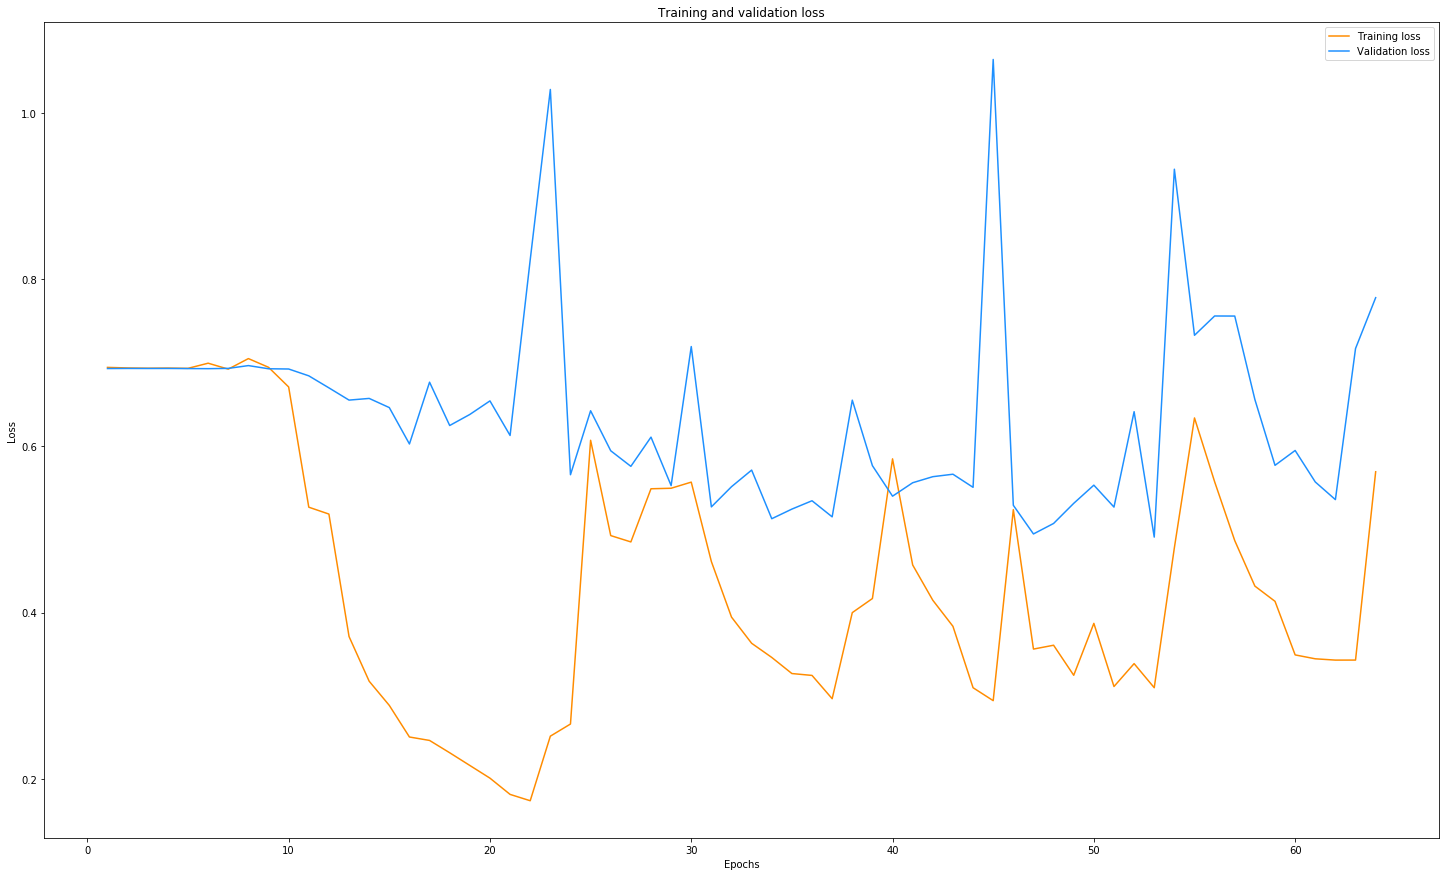

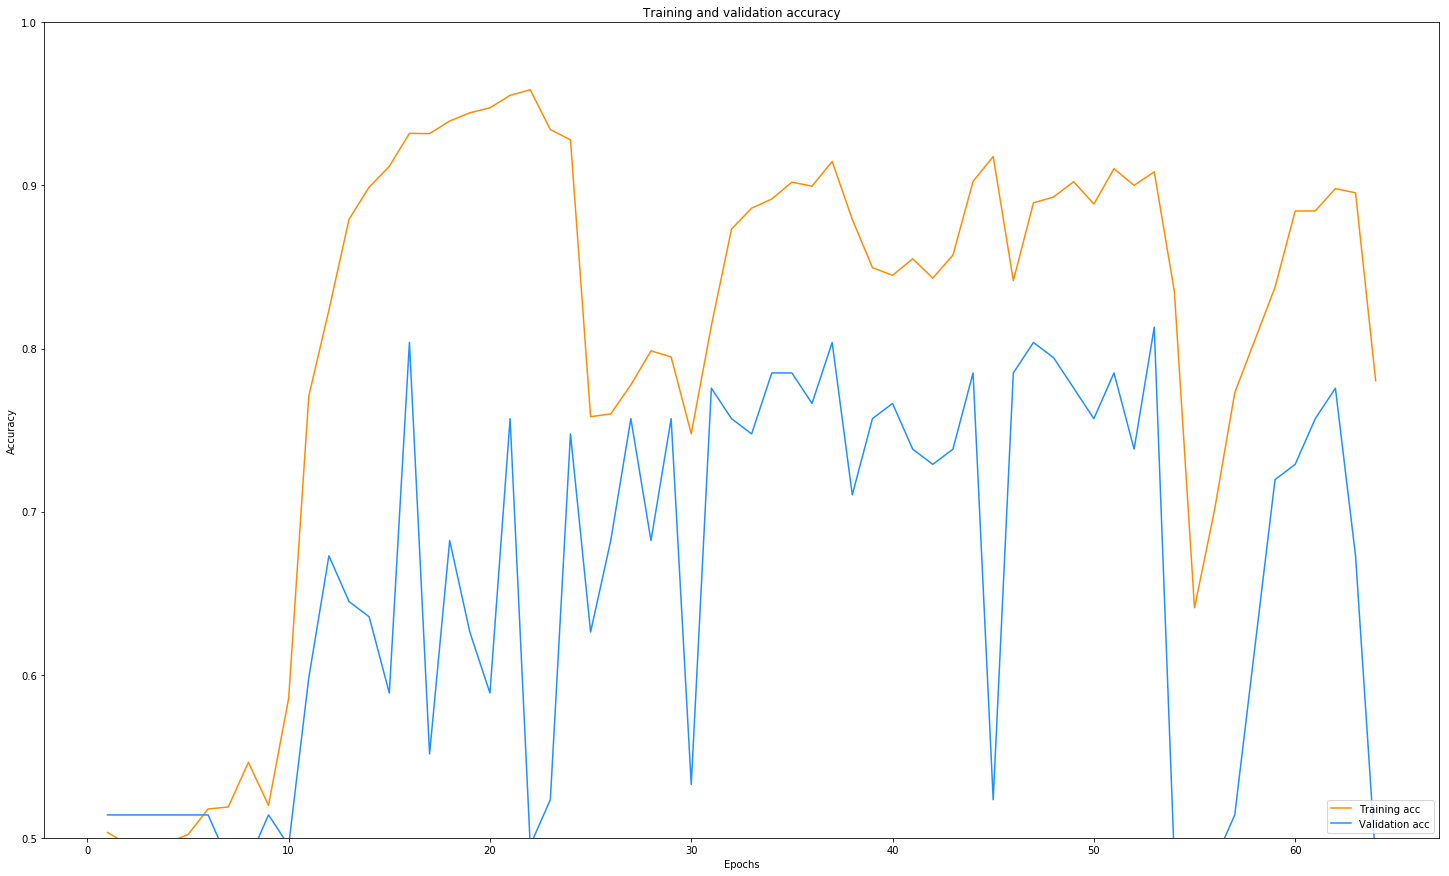

In [0]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(25, 15), facecolor="white")
plt.plot(epochs, loss, 'b', label='Training loss', color="darkorange")
plt.plot(epochs, val_loss, 'b', label='Validation loss', color="dodgerblue")
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(25, 15), facecolor="white")
plt.plot(epochs, acc, 'b', label='Training acc', color="darkorange")
plt.plot(epochs, val_acc, 'b', label='Validation acc', color="dodgerblue")
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()

In [0]:
model = keras.models.load_model("/gdrive/My Drive/Colab Notebooks/runs/GRU_3_layers_1560737367" + "/GRU_3_layers.h5")
timestamp = str(int(time.time()))
output_directory2 = os.path.abspath(os.path.join(os.path.curdir, "/gdrive/My Drive/Colab Notebooks/runs", "GRU_3_layers_ADD_" + timestamp))
checkpoint_path = output_directory2 + "/checkpoints/cp-{epoch:04d}.ckpt"

tb_cb = keras.callbacks.TensorBoard(log_dir=output_directory2, histogram_freq=1,
                                    embeddings_freq=4)
cp_callback = keras.callbacks.ModelCheckpoint(checkpoint_path, verbose=1,
                                              save_weights_only=True, period=4)

optimizer = keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_data, train_label, epochs=64, batch_size=256,
                    validation_split=0.01, callbacks=[tb_cb, cp_callback])
model.save(output_directory2 + '/GRU_3_layers_add.h5')

W0617 04:22:41.819089 140396388104064 callbacks.py:859] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of samples seen.


Train on 10555 samples, validate on 107 samples
Epoch 1/64
  256/10555 [..............................] - ETA: 1:37 - loss: 0.7673 - accuracy: 0.6797

W0617 04:22:56.078119 140396388104064 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (2.442233). Check your callbacks.


10555/10555 [==============================] - 46s 4ms/sample - loss: 0.4552 - accuracy: 0.7953 - val_loss: 0.5909 - val_accuracy: 0.6916
Epoch 2/64
10555/10555 [==============================] - 36s 3ms/sample - loss: 0.4008 - accuracy: 0.8173 - val_loss: 0.5955 - val_accuracy: 0.6729
Epoch 3/64
10555/10555 [==============================] - 36s 3ms/sample - loss: 0.4183 - accuracy: 0.7939 - val_loss: 0.6292 - val_accuracy: 0.6262
Epoch 4/64
10496/10555 [============================>.] - ETA: 0s - loss: 0.4312 - accuracy: 0.7848
Epoch 00004: saving model to /gdrive/My Drive/Colab Notebooks/runs/GRU_3_layers_ADD1560745361/checkpoints/cp-0004.ckpt
10555/10555 [==============================] - 36s 3ms/sample - loss: 0.4308 - accuracy: 0.7854 - val_loss: 0.5640 - val_accuracy: 0.7009
Epoch 5/64
10555/10555 [==============================] - 36s 3ms/sample - loss: 0.3587 - accuracy: 0.8933 - val_loss: 0.5385 - val_accuracy: 0.7664
Epoch 6/64
10555/10555 [==============================] - 

In [0]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)
out_v = io.open(output_directory2 + '/vecs_02.tsv', 'w', encoding='utf-8')
out_m = io.open(output_directory2 + '/meta_02.tsv', 'w', encoding='utf-8')
for word_num in range(vocab_size):
    word = vocab[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

(18765, 256)


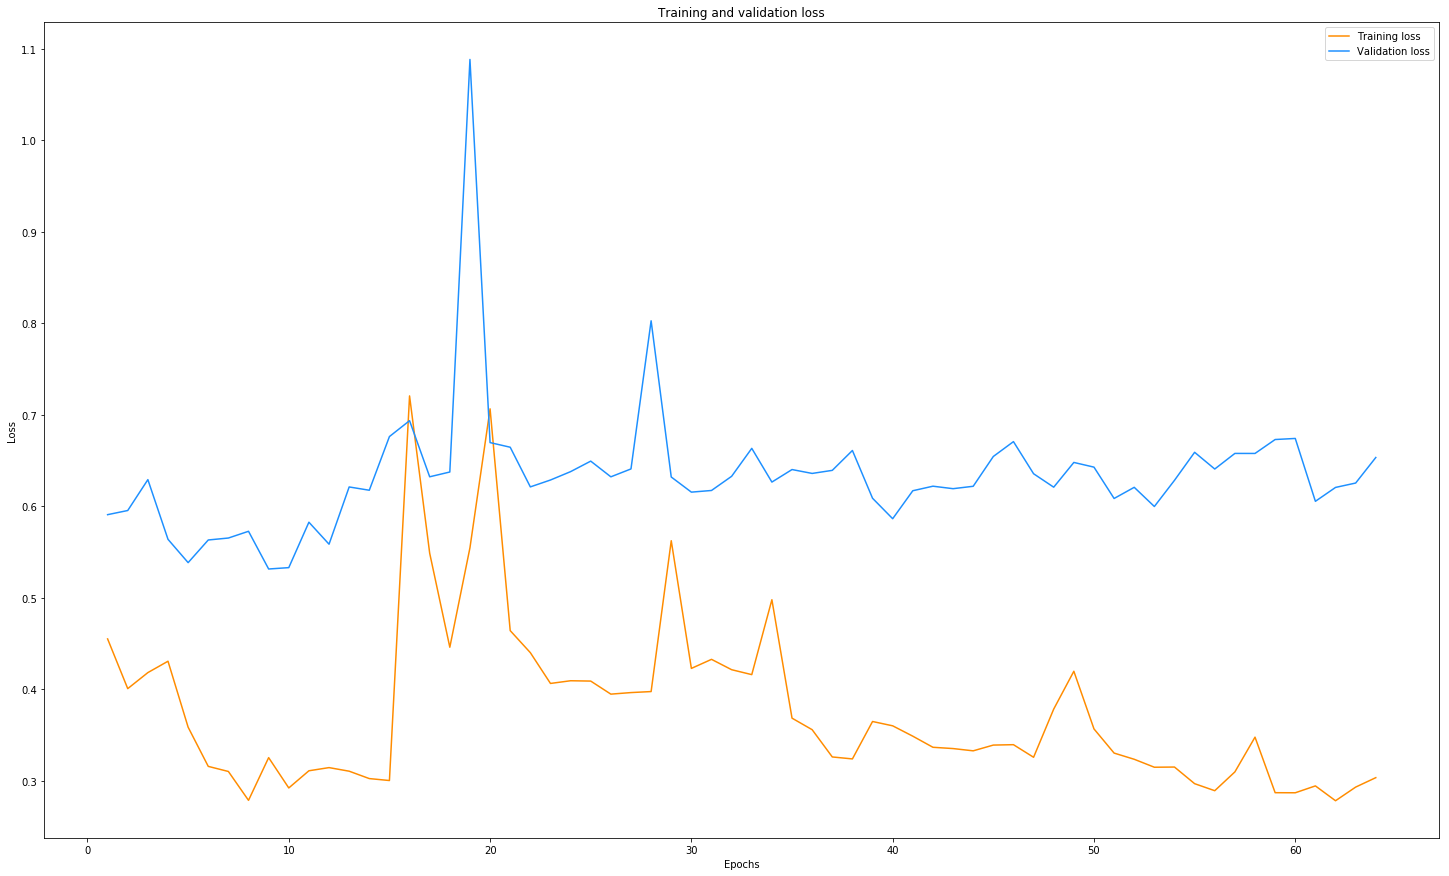

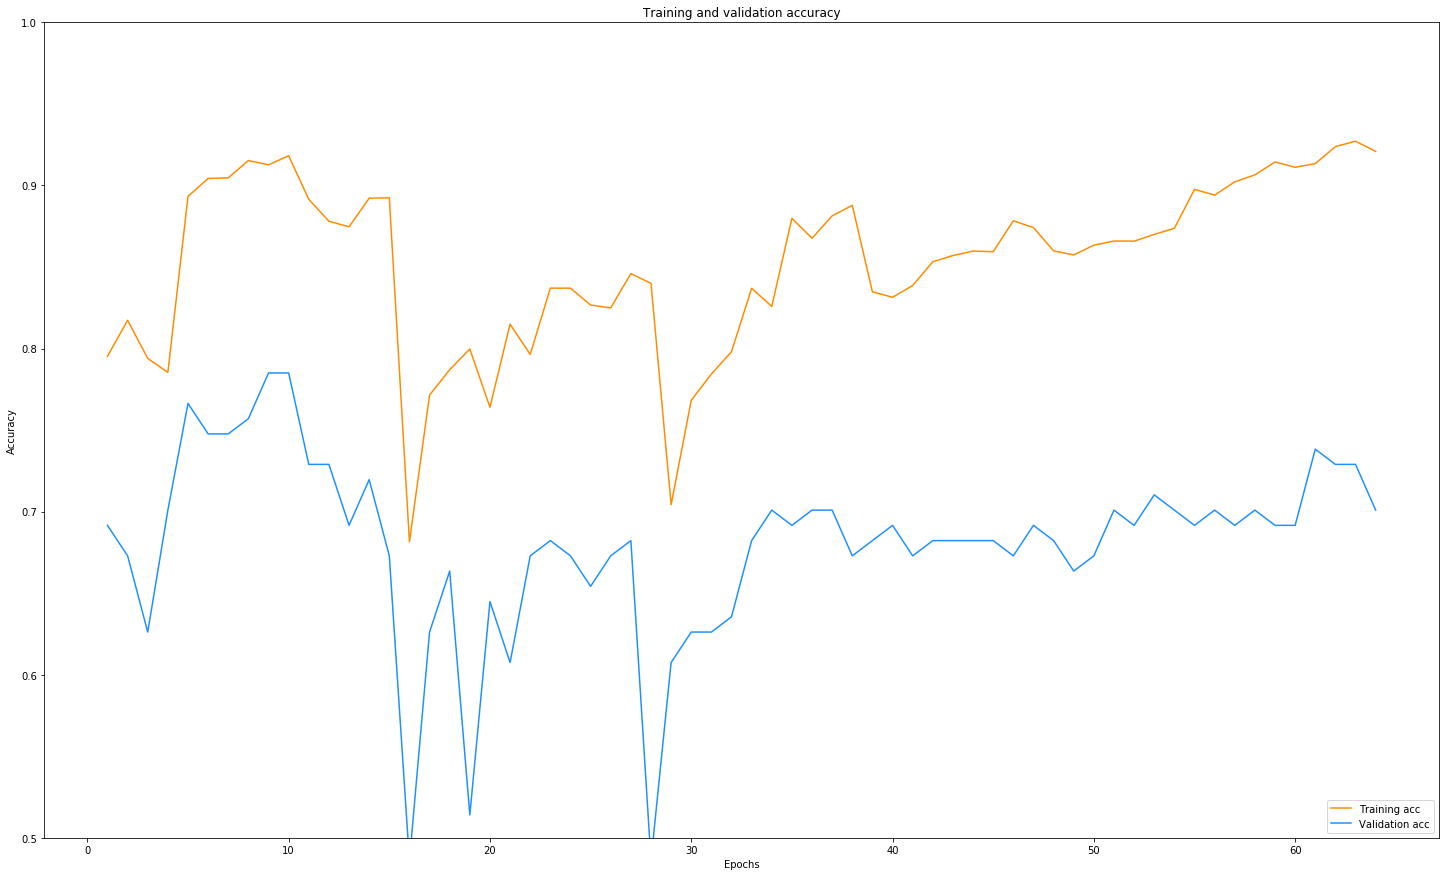

In [0]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(25, 15), facecolor="white")
plt.plot(epochs, loss, 'b', label='Training loss', color="darkorange")
plt.plot(epochs, val_loss, 'b', label='Validation loss', color="dodgerblue")
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(25, 15), facecolor="white")
plt.plot(epochs, acc, 'b', label='Training acc', color="darkorange")
plt.plot(epochs, val_acc, 'b', label='Validation acc', color="dodgerblue")
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()

In [0]:
model = keras.models.load_model(output_directory2 + "/GRU_3_layers_add.h5")
timestamp = str(int(time.time()))
output_directory3 = os.path.abspath(os.path.join(os.path.curdir, "/gdrive/My Drive/Colab Notebooks/runs", "GRU_3_layers_ADD2_" + timestamp))
checkpoint_path = output_directory3 + "/checkpoints/cp-{epoch:04d}.ckpt"

tb_cb = keras.callbacks.TensorBoard(log_dir=output_directory3, histogram_freq=1,
                                    embeddings_freq=4)
cp_callback = keras.callbacks.ModelCheckpoint(checkpoint_path, verbose=1,
                                              save_weights_only=True, period=4)

history = model.fit(train_data, train_label, epochs=128, batch_size=256,
                    validation_split=0.01, callbacks=[tb_cb, cp_callback])
model.save(output_directory3 + '/GRU_3_layers_add.h5')

W0617 05:17:38.150387 140396388104064 callbacks.py:859] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of samples seen.


Train on 10555 samples, validate on 107 samples
Epoch 1/128
  256/10555 [..............................] - ETA: 1:16 - loss: 0.3911 - accuracy: 0.8750

W0617 05:17:46.036043 140396388104064 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (1.882829). Check your callbacks.


10555/10555 [==============================] - 36s 3ms/sample - loss: 0.5494 - accuracy: 0.7881 - val_loss: 0.8112 - val_accuracy: 0.5140
Epoch 2/128
10555/10555 [==============================] - 28s 3ms/sample - loss: 0.5811 - accuracy: 0.6820 - val_loss: 0.7784 - val_accuracy: 0.5140
Epoch 3/128
10555/10555 [==============================] - 27s 3ms/sample - loss: 0.3561 - accuracy: 0.8877 - val_loss: 0.6217 - val_accuracy: 0.7103
Epoch 4/128
10496/10555 [============================>.] - ETA: 0s - loss: 0.3522 - accuracy: 0.9123
Epoch 00004: saving model to /gdrive/My Drive/Colab Notebooks/runs/GRU_3_layers_ADD2_1560748658/checkpoints/cp-0004.ckpt
10555/10555 [==============================] - 28s 3ms/sample - loss: 0.3515 - accuracy: 0.9123 - val_loss: 0.5910 - val_accuracy: 0.7383
Epoch 5/128
10555/10555 [==============================] - 28s 3ms/sample - loss: 0.3398 - accuracy: 0.9155 - val_loss: 0.5826 - val_accuracy: 0.7477
Epoch 6/128
10555/10555 [===========================

In [0]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)
out_v = io.open(output_directory3 + '/vecs.tsv', 'w', encoding='utf-8')
out_m = io.open(output_directory3 + '/meta.tsv', 'w', encoding='utf-8')
for word_num in range(vocab_size):
    word = vocab[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

(18765, 256)


In [0]:
%%monitor_cell 'mobile-test'
output_directory2 = '/gdrive/My Drive/Colab Notebooks/runs/GRU_3_layers_ADD1_1560745361'
model = keras.models.load_model(output_directory2 + "/GRU_3_layers_add.h5")
timestamp = str(int(time.time()))
output_directory4 = os.path.abspath(os.path.join(os.path.curdir, "/gdrive/My Drive/Colab Notebooks/runs", "GRU_3_layers_Mtest_" + timestamp))
checkpoint_path = output_directory4 + "/checkpoints/cp-{epoch:04d}.ckpt"

config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.metadata_path = str(output_directory2 + '/meta_02.tsv')

tb_cb = keras.callbacks.TensorBoard(log_dir=output_directory4, histogram_freq=1,
                                    embeddings_freq=4)
cp_callback = keras.callbacks.ModelCheckpoint(checkpoint_path, verbose=1,
                                              save_weights_only=True, period=4)

history = model.fit(train_data, train_label, epochs=64, batch_size=256,
                    validation_split=0.01, callbacks=[tb_cb, cp_callback])

model.save(output_directory4 + '/GRU_3_layers_Mtest.h5')
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)
out_v = io.open(output_directory4 + '/vecs.tsv', 'w', encoding='utf-8')
out_m = io.open(output_directory4 + '/meta.tsv', 'w', encoding='utf-8')
for word_num in range(vocab_size):
    word = vocab[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

W0617 06:32:14.294138 140389339625216 callbacks.py:859] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of samples seen.


Train on 10555 samples, validate on 107 samples
Epoch 1/64
  256/10555 [..............................] - ETA: 1:18 - loss: 0.4093 - accuracy: 0.8906

W0617 06:32:22.645563 140389339625216 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (1.991337). Check your callbacks.


10555/10555 [==============================] - 36s 3ms/sample - loss: 0.3612 - accuracy: 0.8799 - val_loss: 0.6213 - val_accuracy: 0.7103
Epoch 2/64
10555/10555 [==============================] - 28s 3ms/sample - loss: 0.3121 - accuracy: 0.8867 - val_loss: 0.6148 - val_accuracy: 0.7103
Epoch 3/64
10555/10555 [==============================] - 27s 3ms/sample - loss: 0.3084 - accuracy: 0.8905 - val_loss: 0.6001 - val_accuracy: 0.7196
Epoch 4/64
10496/10555 [============================>.] - ETA: 0s - loss: 0.3035 - accuracy: 0.8890
Epoch 00004: saving model to /gdrive/My Drive/Colab Notebooks/runs/GRU_3_layers_Mtest_1560753134/checkpoints/cp-0004.ckpt
10555/10555 [==============================] - 28s 3ms/sample - loss: 0.3048 - accuracy: 0.8887 - val_loss: 0.6087 - val_accuracy: 0.7103
Epoch 5/64
10555/10555 [==============================] - 28s 3ms/sample - loss: 0.3299 - accuracy: 0.8677 - val_loss: 0.5987 - val_accuracy: 0.7103
Epoch 6/64
10555/10555 [==============================]

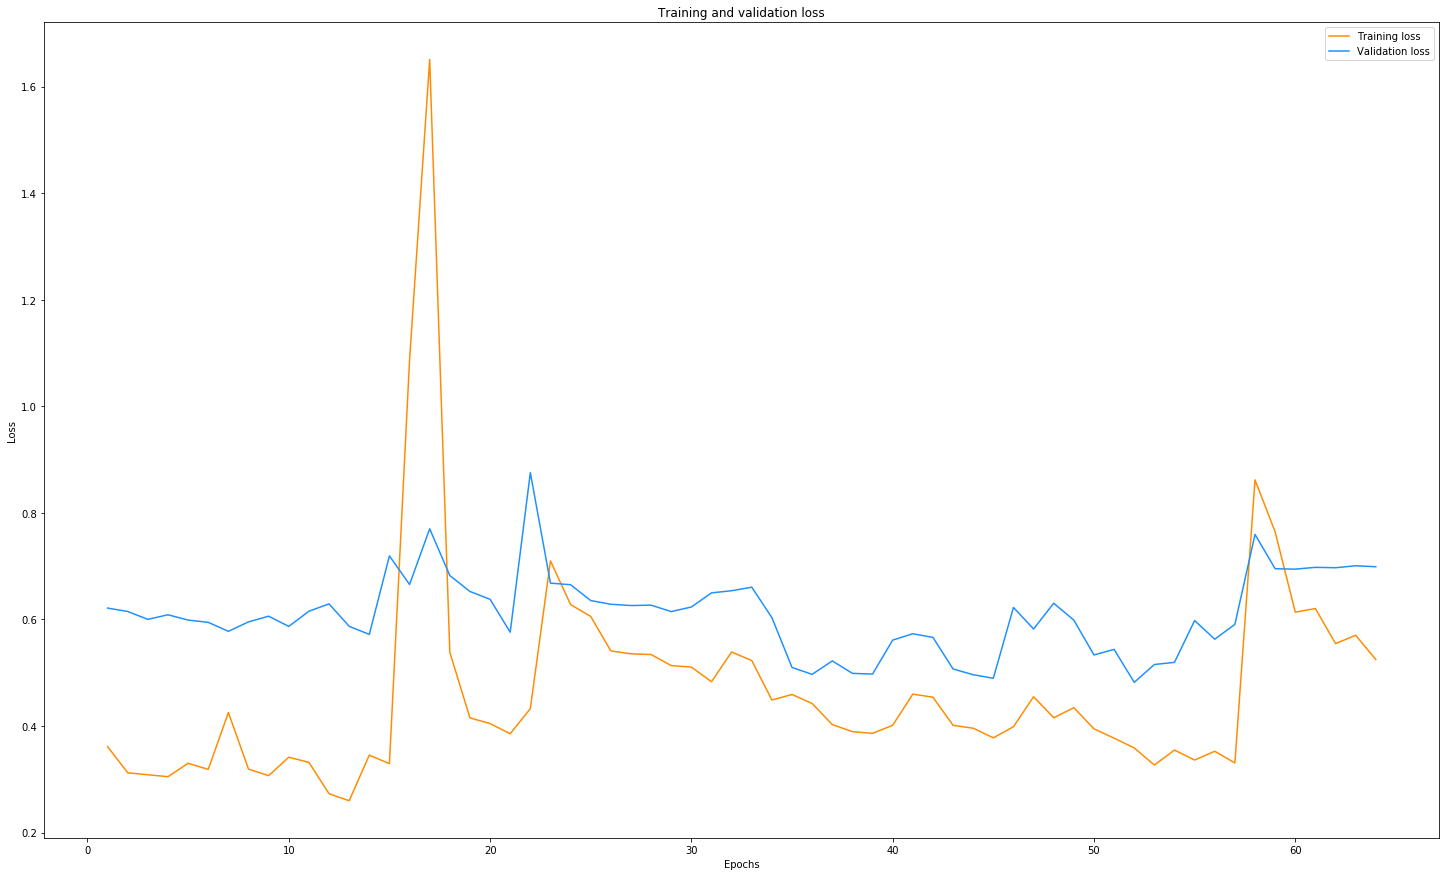

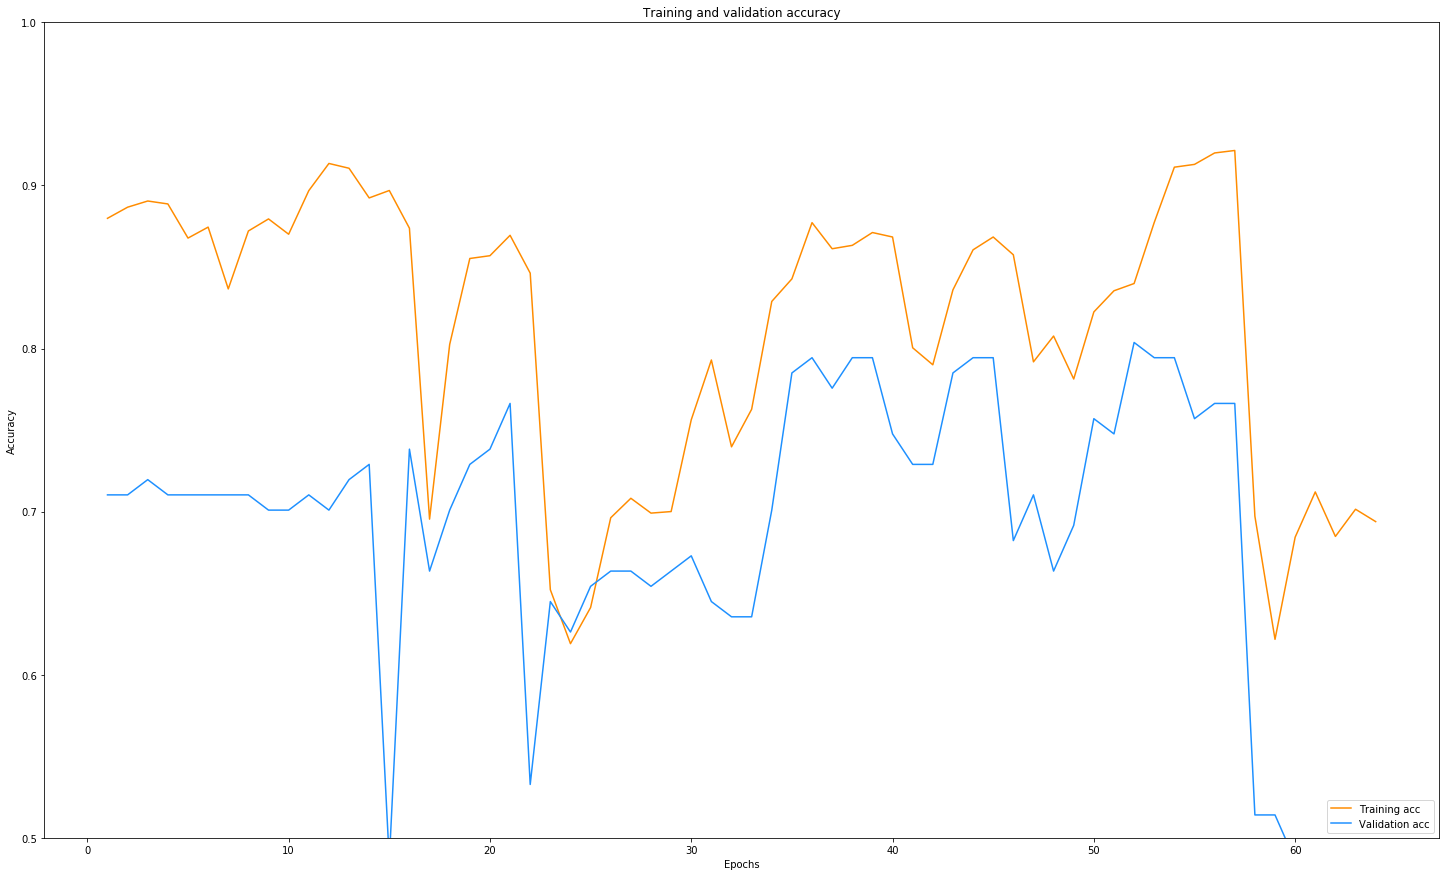

In [0]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(25, 15), facecolor="white")
plt.plot(epochs, loss, 'b', label='Training loss', color="darkorange")
plt.plot(epochs, val_loss, 'b', label='Validation loss', color="dodgerblue")
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(25, 15), facecolor="white")
plt.plot(epochs, acc, 'b', label='Training acc', color="darkorange")
plt.plot(epochs, val_acc, 'b', label='Validation acc', color="dodgerblue")
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()